In [1]:
import os, time, multiprocessing
from test_functions import fnc1

# if on beluga, use environment variable cpu count
if os.getenv('SLURM_CPUS_PER_TASK'):
    nproc=int(os.getenv('SLURM_CPUS_PER_TASK'))
else:
    nproc = multiprocessing.cpu_count()

In [2]:
def fnc2(args):
    t1,t2 = args
    z = fnc1(t1,t2)
    return(z)
    

xs = [0,1,2,3,4,5,6,7,8,9]
ys = [x+1 for x in xs]

argsList = list(zip(xs,ys))

In [3]:
start=time.time()
for args in argsList:
    z = fnc2(args)
    print(z)
print(time.time()-start)

0.0
1.4142135623730951
2.449489742783178
3.4641016151377544
4.47213595499958
5.477225575051661
6.48074069840786
7.483314773547883
8.48528137423857
9.486832980505138
2.524925947189331


In [4]:
start=time.time()
with multiprocessing.Pool(processes=nproc) as p:
    result = p.map(fnc2,argsList)
print(result)
print(time.time()-start)

[0.0, 1.4142135623730951, 2.449489742783178, 3.4641016151377544, 4.47213595499958, 5.477225575051661, 6.48074069840786, 7.483314773547883, 8.48528137423857, 9.486832980505138]
0.8804159164428711


## Apply to CRISPR_distance tools

First, `rho_init`, `overlapping_arrays`, and `size_limits` are computed on the head node.

In [1]:
import CRISPR_functions
from CRISPR_functions import is_overlapping,get_limits_ancestor_sizes,CRISPR_pair
import os,sys,time,itertools,multiprocessing
import numpy as np
from mpmath import mp,mpf,findroot

# if on beluga, use environment variable cpu count
if os.getenv('SLURM_CPUS_PER_TASK'):
    nproc=int(os.getenv('SLURM_CPUS_PER_TASK'))
else:
    nproc = multiprocessing.cpu_count()
mp.dps = 100; mp.pretty = True

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[13,14]]
# arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]

rho_init=mpf(sum([len(ar) for ar in arrays])/len([len(ar) for ar in arrays]))
print(f'rho_init: {rho_init}\n')

overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==1]
print(f'overlapping_arrays: {overlapping_arrays}\n')

non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==0]
print(f'non_overlapping_arrays: {non_overlapping_arrays}\n')

pairList = [CRISPR_pair(pair[0],pair[1]) for pair in overlapping_arrays]

size_lims=get_limits_ancestor_sizes(arrays)
print(f'size_lims: {size_lims}\n')

rho_init: 4.5

overlapping_arrays: [([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8]), ([0, 1, 2, 3, 7, 8], [1, 10, 11, 12, 13]), ([1, 10, 11, 12, 13], [13, 14])]

non_overlapping_arrays: [([9, 2, 3, 4, 5], [1, 10, 11, 12, 13]), ([9, 2, 3, 4, 5], [13, 14]), ([0, 1, 2, 3, 7, 8], [13, 14])]

size_lims: (0, 11)



## Get possible ancestors

Return dictionary of possible ancestors for each pair (element of `overlapping_arrays`).

In [2]:
import multiprocessing

def get_ancestor_dict(args):
    '''Get dictionary of possible ancestors.'''
    pair,size_lims = args
    PAIR=CRISPR_pair(pair[0],pair[1])
    return(PAIR.get_combi(size_lims))

argList = [tuple([array,size_lims]) for array in overlapping_arrays]

with multiprocessing.Pool(processes=nproc) as pool:
    ancestor_dicts = pool.map(get_ancestor_dict,argList)


## Estimate times with fixed $\rho$ for all overlapping pairs

In [3]:
# from CRISPR_functions import OPTIMIZE_t1t2

# t1t2_list=OPTIMIZE_t1t2(overlapping_arrays, rho_init, size_lims)

# pair, rho_init, size_lims
# print(t1t2_list)
from scipy.optimize import minimize,Bounds
from CRISPR_functions import neg_LL_floating_t
from CRISPR_functions import OPTIMIZE_pair_t1t2

# def OPTIMIZE_pair_t1t2(args):
#     '''Provided a set of overlapping arrays and rho, OPTIMIZE_t1t2 finds their best respective divergence times t1,t2 from ancestor to arrays. The output is an array of [t1,t2] of length len(overlapping_arrays)'''
    
#     PAIR, rho, size_lims, ancestor_dict = args

#     x0=[1,1]
#     bnds = ((0, None), (0, None))
# #     optimize=minimize(neg_LL_floating_t,x0,bounds=bounds,method='Powell',args=(rho,PAIR,size_lims))
#     optimize=minimize(neg_LL_floating_t,x0,bounds=bnds,args=(rho,PAIR,size_lims,ancestor_dict)) # method=L-BFGS-B
#     return(tuple(optimize.x))

argList = [(CRISPR_pair(pair[0],pair[1]),rho_init,size_lims,ancestor_dicts[index])
           for index,pair in enumerate(overlapping_arrays)]

# for-loop
start=time.time()
for arg in argList:
    t1t2 = OPTIMIZE_pair_t1t2(arg)
    print(t1t2)
print(f'for-loop time: {time.time()-start}')

# multiprocessing
start=time.time()
with multiprocessing.Pool(processes=nproc) as pool:
    t1t2_list = pool.map(OPTIMIZE_pair_t1t2,argList)
print(f'multiprocessing time: {time.time()-start}')
print(t1t2_list)


(1.9563740599768615, 2.5604747174122973)
(2.7673633194504283, 2.262374344745272)
(6.042246969016091, 0.0)
for-loop time: 1.5477161407470703
multiprocessing time: 0.9656200408935547
[(1.9563740599768615, 2.5604747174122973), (2.7673633194504283, 2.262374344745272), (6.042246969016091, 0.0)]


In [4]:
from CRISPR_functions import OPTIMIZE_rho


(rho_update, neg_LL_update) = OPTIMIZE_rho(t1t2_list,pairList,size_lims,non_overlapping_arrays,ancestor_dicts)
print(rho_update)
print(neg_LL_update)

[4.52685565]
[48.281157456288945]


In [1]:
# %%writefile Run_CRISPR_Distance_multiprocessing.py

import CRISPR_functions
from scipy.optimize import minimize,Bounds
from CRISPR_functions import neg_LL_floating_t
from CRISPR_functions import OPTIMIZE_pair_t1t2,OPTIMIZE_rho
from CRISPR_functions import is_overlapping,get_limits_ancestor_sizes,CRISPR_pair
from CRISPR_functions import get_distance_matrix_from_phylogeny
from CRISPR_functions import phylogeny_from_CRISPR
from Bio import Phylo
from Bio.Phylo import BaseTree,draw_ascii
import os,sys,time,itertools,multiprocessing
import numpy as np
import pandas as pd
from mpmath import mp,mpf,findroot

def get_nproc():
    # if on beluga, use environment variable cpu count
    if os.getenv('SLURM_CPUS_PER_TASK'):
        return(int(os.getenv('SLURM_CPUS_PER_TASK')))
    else:
        return(multiprocessing.cpu_count())
    
def get_ancestor_dict(args):
    '''Get dictionary of possible ancestors.'''
    pair,size_lims = args
    PAIR=CRISPR_pair(pair[0],pair[1])
    return(PAIR.get_combi(size_lims))

def main(arrays):

    # get number of cores
    nproc = get_nproc()
    #set precision
    mp.dps = 100; mp.pretty = True
    # initialize rho
    rho_init=mpf(sum([len(ar) for ar in arrays])/len([len(ar) for ar in arrays]))
    # overlapping pairs (list)
    overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2))
                        if is_overlapping(pair[0],pair[1])==1]
    # non-overlapping pairs (list)
    non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2))
                            if is_overlapping(pair[0],pair[1])==0]
    # pair list (list of PAIR objects)
    pairList = [CRISPR_pair(pair[0],pair[1]) for pair in overlapping_arrays]
    # size limits
    size_lims=get_limits_ancestor_sizes(arrays)
    # generate ancestor dictionary
    argList = [tuple([array,size_lims]) for array in overlapping_arrays]
    with multiprocessing.Pool(processes=nproc) as pool:
        ancestor_dicts = pool.map(get_ancestor_dict,argList)

    # first iteration: get initial t1s,t2s, and rho
    with multiprocessing.Pool(processes=nproc) as pool:
        # create argList for optimization of t1 and t2
        argList = [(pair,rho_init,size_lims,ancestor_dicts[index])
                   for index,pair in enumerate(pairList)]
        t1t2_list = pool.map(OPTIMIZE_pair_t1t2,argList)
    rho_update, neg_LL_update = OPTIMIZE_rho(t1t2_list,pairList,size_lims,non_overlapping_arrays,ancestor_dicts)

    Init_LL=[np.inf]
    i=0
    rho_list=[rho_update[0]]
    convergence='False'
    
    # optimization of rho, and (t1, t2) of each pair
    while convergence=='False':
        i+=1
        print('iteration '+str(i)+'...')
        previous_LL=Init_LL[-1]
        # optimize t1 and t2
        with multiprocessing.Pool(processes=nproc) as pool:
            argList = [(pair,rho_update,size_lims,ancestor_dicts[index])
                       for index,pair in enumerate(pairList)]
            t1t2_list = pool.map(OPTIMIZE_pair_t1t2,argList)
        # optimize rho and return neg log likelihood
        rho_update, neg_LL_update = OPTIMIZE_rho(t1t2_list,pairList,size_lims,non_overlapping_arrays,ancestor_dicts)
        # check for convergence
#         print(Init_LL, neg_LL_update, rho_update, rho_list)
        Init_LL+=[neg_LL_update[0]]
        rho_list+=[rho_update[0]]
        if neg_LL_update[0]>previous_LL:
            convergence='True'
    final_dist=dict(zip(pairList,t1t2_list))
    
    # Get phylogeny and distance matrix
    Tree,labels=phylogeny_from_CRISPR(arrays,final_dist)
    dist=get_distance_matrix_from_phylogeny(Tree)
    print(f'Final rho: {rho_list[-1]}')
    return(Tree,dist,labels)
    
    
if __name__=='__main__':
    
#     filename = sys.argv[1]
#     filename = 'test_arrays.txt'
    f=open('prep_for_Arlequin/arrays_with_at_least_5percent_in_reads.txt','r')
    lines=f.read().splitlines()
    lines=[line.split('\t')[2] for line in lines]
    f.close()
    myarrays=[line.split(',') for line in lines]
    arrays=myarrays
#     with open(filename,'r') as f:
#         lines = f.read().splitlines()
#     arrays = [line.split(',') for line in lines]
    start=time.time()
    Tree,dist,labels = main(arrays=arrays)
    print('time to completion:',time.time()-start, 'seconds')

FileNotFoundError: [Errno 2] No such file or directory: 'prep_for_Arlequin/arrays_with_at_least_5percent_in_reads.txt'

In [2]:
import CRISPR_functions
import time

if __name__=='__main__':
    
    #filename = sys.argv[1]
    filename = 'Mydata/arrays_in_whole_dataset_v6.txt'
#     f=open('Mydata/prep_for_Arlequin/arrays_with_at_least_5percent_in_reads.txt','r')
#     lines=f.read().splitlines()
#     lines=[line.split('\t')[2] for line in lines]
#     f.close()
#     myarrays=[line.split(',') for line in lines]
#     arrays=myarrays
    with open(filename,'r') as f:
        lines = f.read().splitlines()
    arrays = [line.split(',') for line in lines]
    start=time.time()
    Tree,dist,labels = CRISPR_functions.main(arrays=arrays)
    print('time to completion:',time.time()-start, 'seconds')

number of processeors: 16

Generating ancestors...
Complete.

Initial estimates...
Estimating initial t1 and t2 lists...
Complete. Updated rho...


KeyboardInterrupt: 

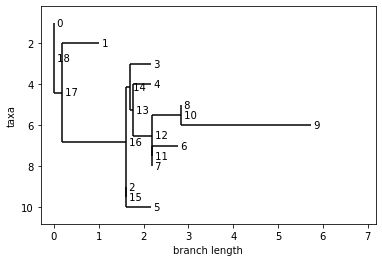

,0,1,2,3,4,5,6,7,8,9
0,NaN,1.00906,1.61722,2.17475,2.17475,2.16263,2.75987,2.18786,2.84347,5.74279
1,1.00906,NaN,2.26488,2.82242,2.82242,2.8103,3.40753,2.83553,3.49114,6.39045
2,1.61722,2.26488,NaN,0.558914,0.558914,0.545415,1.14403,0.572023,1.22764,4.12695
3,2.17475,2.82242,0.558914,NaN,0.956561,1.10433,1.54168,0.96967,1.62528,4.5246
4,2.17475,2.82242,0.558914,0.956561,NaN,1.10433,1.40558,0.833568,1.48918,4.38849
5,2.16263,2.8103,0.545415,1.10433,1.10433,NaN,1.68945,1.11744,1.77305,4.67236
6,2.75987,3.40753,1.14403,1.54168,1.40558,1.68945,NaN,0.572008,1.23146,4.13077
7,2.18786,2.83553,0.572023,0.96967,0.833568,1.11744,0.572008,NaN,0.659449,3.55876
8,2.84347,3.49114,1.22764,1.62528,1.48918,1.77305,1.23146,0.659449,NaN,2.89931
9,5.74279,6.39045,4.12695,4.5246,4.38849,4.67236,4.13077,3.55876,2.89931,NaN


In [2]:
from Bio import Phylo
Phylo.draw(Tree)
dist

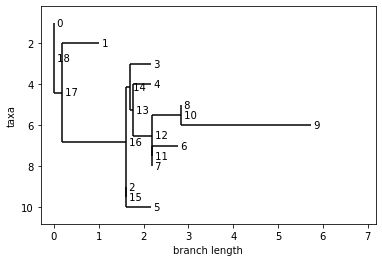

,0,1,2,3,4,5,6,7,8,9
0,NaN,1.00906,1.61722,2.17475,2.17475,2.16263,2.75987,2.18786,2.84347,5.74279
1,1.00906,NaN,2.26488,2.82242,2.82242,2.8103,3.40753,2.83553,3.49114,6.39045
2,1.61722,2.26488,NaN,0.558914,0.558914,0.545415,1.14403,0.572023,1.22764,4.12695
3,2.17475,2.82242,0.558914,NaN,0.956561,1.10433,1.54168,0.96967,1.62528,4.5246
4,2.17475,2.82242,0.558914,0.956561,NaN,1.10433,1.40558,0.833568,1.48918,4.38849
5,2.16263,2.8103,0.545415,1.10433,1.10433,NaN,1.68945,1.11744,1.77305,4.67236
6,2.75987,3.40753,1.14403,1.54168,1.40558,1.68945,NaN,0.572008,1.23146,4.13077
7,2.18786,2.83553,0.572023,0.96967,0.833568,1.11744,0.572008,NaN,0.659449,3.55876
8,2.84347,3.49114,1.22764,1.62528,1.48918,1.77305,1.23146,0.659449,NaN,2.89931
9,5.74279,6.39045,4.12695,4.5246,4.38849,4.67236,4.13077,3.55876,2.89931,NaN


In [5]:
from Bio import Phylo
Phylo.draw(Tree)
dist

In [7]:
!pip install --no-index biopython


Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/nix/avx512, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/nix/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/nix/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [6]:
import pandas as pd


labels = {'1':'jfksl','2':1293,'3':'12931'}
df = pd.DataFrame.from_dict(labels, orient="index")

df.to_csv('Output/'+'labels.csv')
